## Import modules

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import scrublet as scr
import session_info

In [2]:
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi = 120, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')
session_info.show()

## Functions

## Read in anndata

In [3]:
adata = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/QC/scRNA_foetal_prefilter.h5ad')
adata

AnnData object with n_obs × n_vars = 205457 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval'
    var: 'gene_name', 'feature_type', 'ambient_expression-0', 'ambient_expression-1', 'ambient_expression-10', 'ambient_expression-11', 'ambient_expression-12', 'ambient_expression-13', 'ambient_expression-14', 'ambient_expression-15', 'ambient_expression-16', 'ambient_expression-17', 'ambient_expression-18', 'ambient_expression-19', 'ambient_expression-2', 'ambient_expression-3', 'ambient_expression-4', 'ambient_expression-5', 'ambient_expression-6', 'ambient_expression-7', 'ambient_expression-8', 'ambient_expression-9'
    obsm: 'latent_gene_encoding'

In [4]:
adata.obs['sangerID'].value_counts()

Sinha_F2             24275
Sinha_E2             24227
BHF_F_Hea11192328    21714
Sinha_E8             17219
BHF_F_Hea11192324    16688
BHF_F_Hea11192326    14117
BHF_F_Hea11192325    10676
Sinha_F4             10652
BHF_F_Hea11192327     9130
BHF_F_Hea10402918     8010
Sinha_F7              6973
Sinha_D8              6714
Sinha_A1              6640
Sinha_B1              5988
BHF_F_Hea11192323     4893
Sinha_C8              4587
BHF_F_Hea10402917     3752
Sinha_G4              3389
Sinha_F8              3203
Sinha_G7              2610
Name: sangerID, dtype: int64

## Remove doublets

<AxesSubplot:>

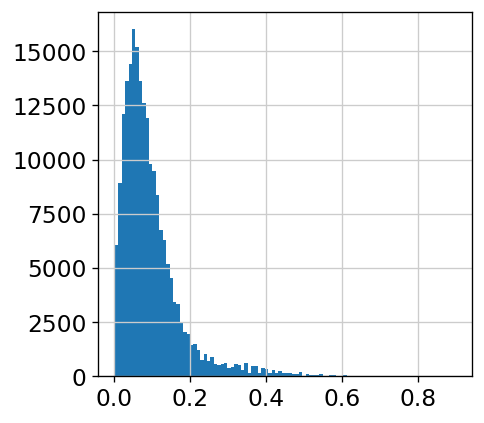

In [5]:
adata.obs['scrublet_score'].hist(bins=100)

In [6]:
# set threshold (arbitrary)
dbl_score_thresh=0.15

prop = np.sum(adata.obs['scrublet_score']>=dbl_score_thresh)/len(adata)
print(f'proportion of doublets: {prop}')

proportion of doublets: 0.15717644081243276


In [7]:
# Save doublet ids
doublets = adata.obs_names[(adata.obs['scrublet_score']<dbl_score_thresh)==False]
with open('/nfs/team205/heart/anndata_objects/Foetal/QC/scRNA_rm-doublets.txt', 'w') as f:
    for line in doublets:
        f.write(line)
        f.write('\n')

# Remove doublets
adata = adata[adata.obs['scrublet_score']<dbl_score_thresh]
print(adata.shape)

(173164, 36601)


## Remove low quality cells

In [8]:
sc.pp.filter_cells(adata, min_genes=500, inplace=True)
sc.pp.filter_cells(adata, min_counts=1000, inplace=True)
print(adata.shape)

filtered out 56470 cells that have less than 500 genes expressed
Trying to set attribute `.obs` of view, copying.
filtered out 1964 cells that have less than 1000 counts


(114730, 36601)


In [9]:
adata.obs['sangerID'].value_counts()

BHF_F_Hea11192328    12134
BHF_F_Hea11192324    10697
BHF_F_Hea11192326     9926
Sinha_E2              8388
Sinha_F4              8149
Sinha_E8              8089
BHF_F_Hea11192325     7532
Sinha_F2              6849
BHF_F_Hea11192327     5895
Sinha_D8              5213
Sinha_F7              4983
BHF_F_Hea10402918     4402
Sinha_A1              4202
Sinha_C8              3745
BHF_F_Hea11192323     3533
Sinha_B1              3361
Sinha_G4              2404
BHF_F_Hea10402917     2238
Sinha_G7              1660
Sinha_F8              1330
Name: sangerID, dtype: int64

## Compute QC stats

In [10]:
adata.var['mt'] = adata.var['gene_name'].str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
adata.var['ribo'] = adata.var['gene_name'].str.startswith('RPS','RPL')  # annotate the group of ribosomal genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo'], percent_top=None, log1p=True, inplace=True)

### Sanger ###


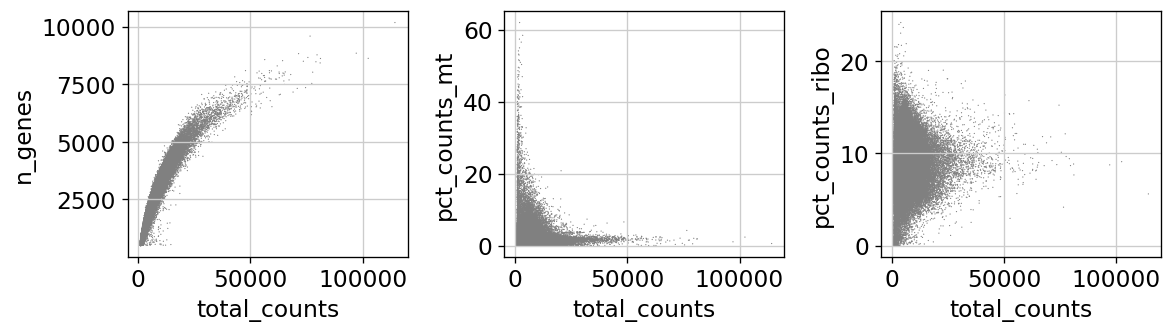

### CSCI ###


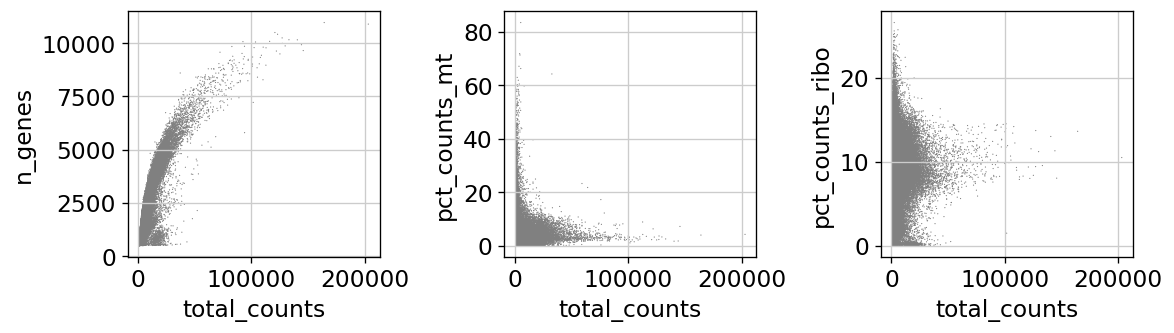

In [11]:
plt.rcParams['figure.figsize'] = [3, 2]

print('### Sanger ###')
fig,axs=plt.subplots(nrows=1,ncols=3,figsize=(10,3))
sc.pl.scatter(adata[adata.obs['facility']=='Sanger'], x='total_counts', y='n_genes', show=False, ax=axs[0])
sc.pl.scatter(adata[adata.obs['facility']=='Sanger'], x='total_counts', y='pct_counts_mt', show=False, ax=axs[1])
sc.pl.scatter(adata[adata.obs['facility']=='Sanger'], x='total_counts', y='pct_counts_ribo', show=False, ax=axs[2])

fig.tight_layout()
plt.show()

plt.rcParams['figure.figsize'] = [3, 2]

print('### CSCI ###')
fig,axs=plt.subplots(nrows=1,ncols=3,figsize=(10,3))
sc.pl.scatter(adata[adata.obs['facility']=='CSCI'], x='total_counts', y='n_genes', show=False, ax=axs[0])
sc.pl.scatter(adata[adata.obs['facility']=='CSCI'], x='total_counts', y='pct_counts_mt', show=False, ax=axs[1])
sc.pl.scatter(adata[adata.obs['facility']=='CSCI'], x='total_counts', y='pct_counts_ribo', show=False, ax=axs[2])

fig.tight_layout()
plt.show()

## Remove cells exceeding the ribo/mito threshold

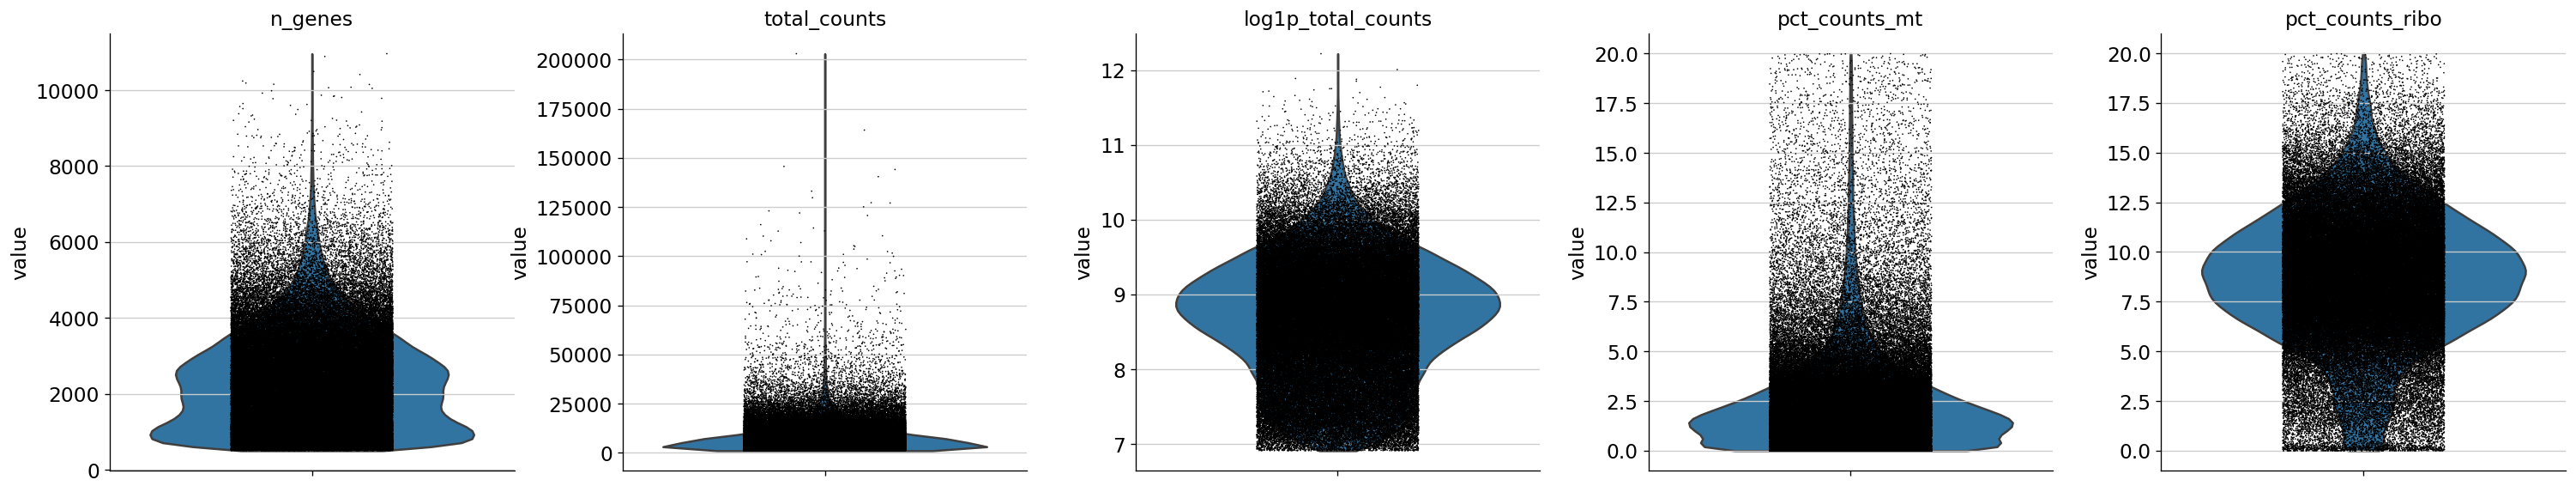

In [12]:
plt.rcParams['figure.figsize'] = [2, 2]
adata = adata[adata.obs['pct_counts_mt'] < 20, :]
adata = adata[adata.obs['pct_counts_ribo'] < 20, :]
sc.pl.violin(adata, ['n_genes', 'total_counts','log1p_total_counts', 'pct_counts_mt', 'pct_counts_ribo'],jitter = 0.2, multi_panel = True)

Trying to set attribute `.uns` of view, copying.


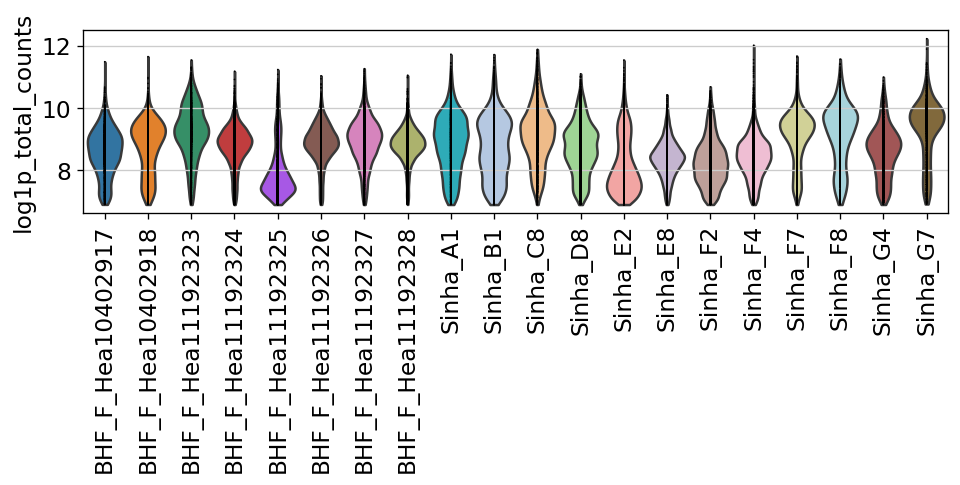

In [13]:
sc.settings.set_figure_params(dpi = 120, color_map = 'RdPu')
plt.rcParams['figure.figsize'] = [8, 2]
sc.pl.violin(adata,keys=['log1p_total_counts'],groupby='sangerID',rotation=90,jitter=False)

In [14]:
print(adata.shape)
adata.obs['sangerID'].value_counts()

(113279, 36601)


BHF_F_Hea11192328    12086
BHF_F_Hea11192324    10568
BHF_F_Hea11192326     9896
Sinha_E2              8327
Sinha_E8              8079
Sinha_F4              8052
BHF_F_Hea11192325     7515
Sinha_F2              6807
BHF_F_Hea11192327     5869
Sinha_D8              4987
Sinha_F7              4837
BHF_F_Hea10402918     4371
Sinha_A1              4118
Sinha_C8              3551
BHF_F_Hea11192323     3420
Sinha_B1              3293
Sinha_G4              2352
BHF_F_Hea10402917     2232
Sinha_G7              1623
Sinha_F8              1296
Name: sangerID, dtype: int64

## Calculate RBC score 

In [15]:
adata_c = adata.copy()

adata_c.var.set_index('gene_name',inplace=True)
adata_c.var_names = adata_c.var_names.astype('str')
adata_c.var_names_make_unique()

sc.pp.filter_genes(adata_c, min_cells=3)
sc.pp.normalize_total(adata_c, target_sum=1e4)
sc.pp.log1p(adata_c)

filtered out 5479 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:01)


In [16]:
# scoring hemoglobin genes
# HGNC, Hemoglobin subunits, groupID:940
genes=['HBA1','HBA2','HBB','HBD','HBE1','HBG1','HBG2','HBM','HBQ1','HBZ']
sc.tl.score_genes(adata_c,gene_list=genes,score_name='HB_score')

computing score 'HB_score'
    finished: added
    'HB_score', score of gene set (adata.obs).
    199 total control genes are used. (0:00:04)


In [17]:
len(adata_c.obs['sangerID'].unique())

20

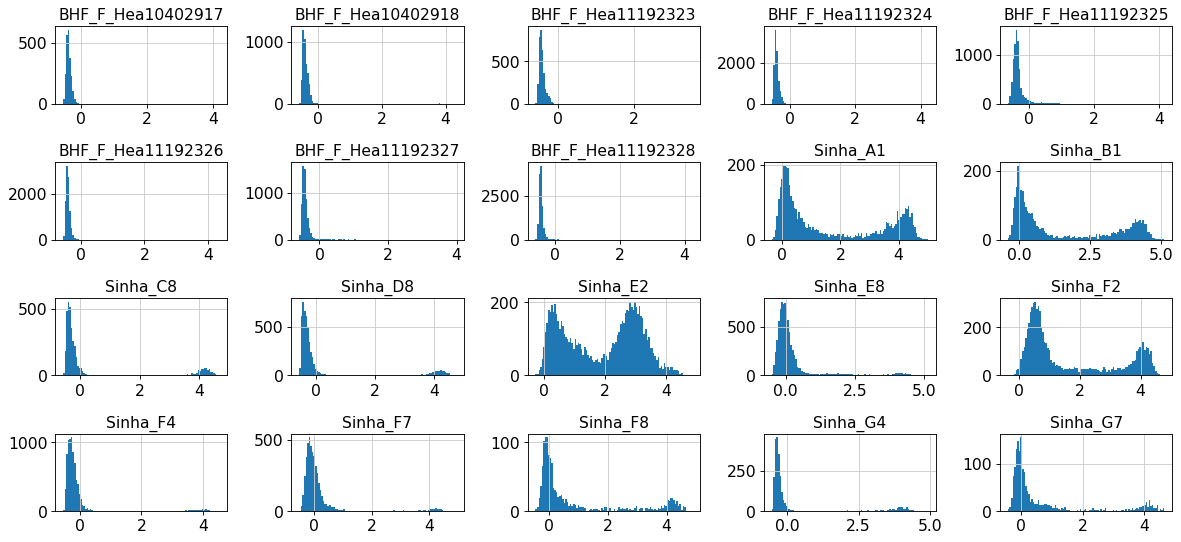

In [18]:
sc.settings.set_figure_params(dpi = 80, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')

fig,axs=plt.subplots(nrows=4,ncols=5,figsize=(15,7))

for i,ID in enumerate(adata_c.obs['sangerID'].unique()):
    sample = adata_c[adata_c.obs['sangerID']==ID]
    axs[i//5,i%5].hist(sample.obs['HB_score'],bins=100)
    axs[i//5,i%5].set_title(ID)

fig.tight_layout()
plt.show()

In [19]:
# add HB score to original adata
adata.obs.loc[adata_c.obs_names,'HB_score']=adata_c.obs['HB_score']

## Remove RBCs

In [20]:
HBscore_thresh=2

adata=adata[adata.obs['HB_score']<HBscore_thresh]
print(adata.shape)

(100463, 36601)


## Save

In [21]:
# save
adata.write('/nfs/team205/heart/anndata_objects/Foetal/QC/scRNA_foetal.h5ad')
adata

View of AnnData object with n_obs × n_vars = 100463 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score'
    var: 'gene_name', 'feature_type', 'ambient_expression-0', 'ambient_expression-1', 'ambient_expression-10', 'ambient_expression-11', 'ambient_expression-12', 'ambient_expression-13', 'ambient_expression-14', 'ambient_expression-15', 'ambient_expression-16', 'ambient_expression-17', 'ambient_expression-18', 'ambient_expression-19', 'ambient_expression-2', '

In [22]:
adata.obs['sangerID'].value_counts()

BHF_F_Hea11192328    12056
BHF_F_Hea11192324    10553
BHF_F_Hea11192326     9876
Sinha_F4              7621
BHF_F_Hea11192325     7512
Sinha_E8              7511
BHF_F_Hea11192327     5865
Sinha_F7              4545
Sinha_F2              4495
Sinha_D8              4377
BHF_F_Hea10402918     4340
Sinha_E2              3913
BHF_F_Hea11192323     3418
Sinha_C8              2989
Sinha_A1              2604
BHF_F_Hea10402917     2227
Sinha_B1              2145
Sinha_G4              2030
Sinha_G7              1372
Sinha_F8              1014
Name: sangerID, dtype: int64